# Connect to GDrive and set working directory
## !! Skip if you run in local !!
1. Add a shortcut for working directory('IDPCode') to your drive as depicted below:
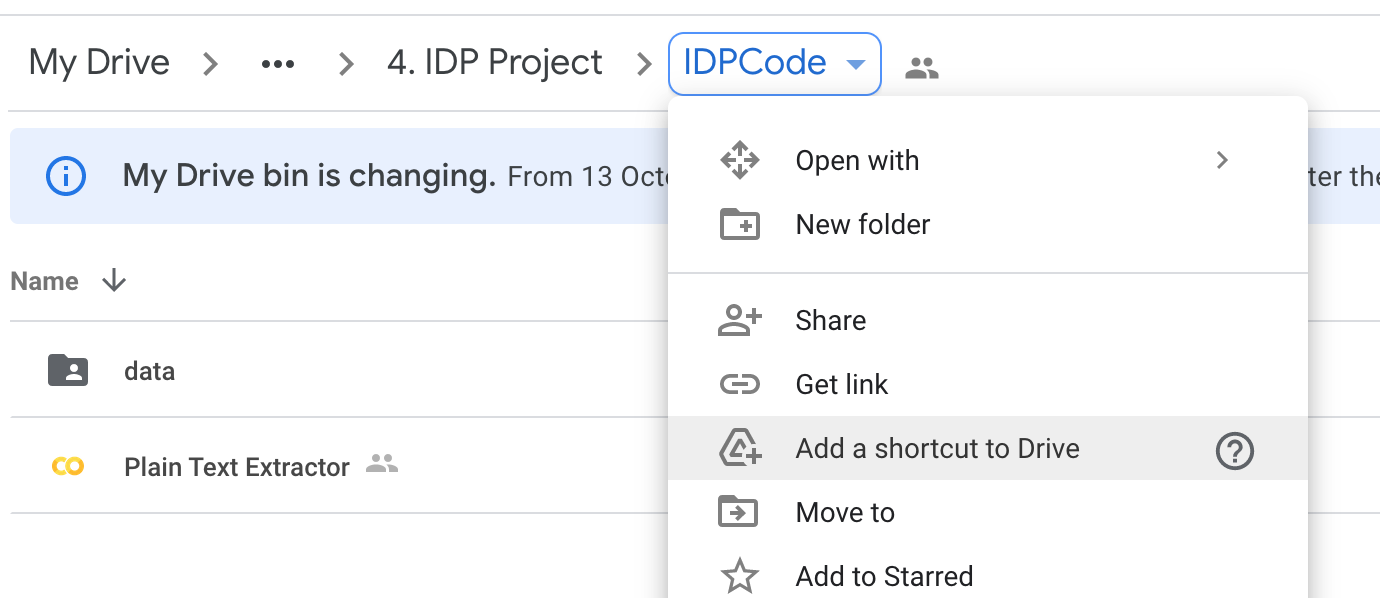
2. Run the command below to connect the GDrive:


In [ ]:
# https://github.com/njanakiev/folderstats
# https://janakiev.com/blog/python-filesystem-analysis/
# https://networkx.org/documentation/stable/
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/IDPCode/

In [5]:
!pip install xlrd
!pip install spacy
!pip install gensim
!pip install ipython-autotime
!pip install pickle5
!pip install textacy

You should consider upgrading via the '/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/bin/python -m pip install --upgrade pip' command.
  Using cached textacy-0.10.1-py3-none-any.whl (183 kB)
Processing /Users/farukcankaya/Library/Caches/pip/wheels/a2/a5/34/f960a47ca5c06b0e91b6f48117a79a66f53a879f8fac9529bf/pyemd-0.5.1-cp38-cp38-macosx_10_14_x86_64.whl
  Using cached Pyphen-0.10.0-py3-none-any.whl (1.9 MB)
  Using cached cachetools-4.2.0

Processing /Users/farukcankaya/Library/Caches/pip/wheels/12/80/98/b62b7fba2c0b84c34d515324548a3205c078ae0109293fb617/cytoolz-0.11.0-cp38-cp38-macosx_10_14_x86_64.whl
  Using cached toolz-0.11.1-py3-none-any.whl (55 kB)
You should consider upgrading via the '/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/bin/python -m pip install --upgrade pip' command.
time: 15.5 s


# Start from here if you run in local !!

In [4]:
import pandas as pd
import numpy as np
import pickle5 as pickle
import gensim

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# show execution time of cells
%load_ext autotime

# CHANGE PATH FOR THE DATASET FOLDER
DATA_DIRECTORY='/Users/farukcankaya/FC/GoogleDrive/AllPapers'


time: 287 µs


In [5]:
# Utility functions
def remove_dollar_sign(text):
  '''
  While drawing title count distribution, mathplotlib throws an error.
  Because some titles have dollar sign('$'). This method is used to clear the sign.
  '''
  
  text = str(text).replace('$', '\$')
  return text

import re
import string
import textacy
from textacy import preprocessing
def clean_text(text):
  '''
  Eliminates links, non alphanumerics, and punctuation.
  Returns lower case text.
  '''  
  
  # Convert to string
  text = str(text)
  # Remove non-ascii
  text = text.encode('ascii', 'ignore').decode('ascii')
  # Remove links
  text = re.sub('(?:(?:https?|ftp):\/\/)?[\w/\-?=%.]+\.[\w/\-?=%.]+', '', text)
  # Remove E-Mail addresses
  text = re.sub(r'\b[a-z]+@[a-z]+\b', r'', str(text))
  # replace words with less than 2 characters
  text = re.sub(r'\b[a-z]{1,2}\b', r'', str(text))
  # Remove non-alphanumerics
  text = re.sub('\w*\d\w*', ' ', text)
  # Remove punctuation and lowercase
  text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text.lower())
  # Remove newline characters
  text = re.sub("\n", r' ', text)
  # Remove text in square brackets
  text = re.sub(r'\[.*?\]', '', text)
  # Remove words containing numbers
  text = re.sub(r'\w*\d\w*', '', text)
  # https://textacy.readthedocs.io/en/0.10.1/_modules/textacy/preprocessing/normalize.html
  text = textacy.preprocessing.normalize.normalize_whitespace(str(text))
    
  return text

import spacy
nlp = spacy.load('en')
def lemmatizer(text, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):        
  sent = []
  doc = nlp(text)
#  for word in doc:
#    sent.append(word.lemma_)
  sent =  [token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]
    
  return " ".join(sent)

# Lemmatization, remove pronouns.
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        texts_out.append(lemmatizer(" ".join(sent), allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']))
    return texts_out

def remove_stopwords(text):
  clean_text = []
  for word in text.split(' '):
    if word not in stop_list and (len(word) > 2):
      clean_text.append(word)
  
  return ' '.join(clean_text)

def display_topics(model, feature_names, no_top_words, no_top_topics, topic_names=None):
  count = 0
  for ix, topic in enumerate(model.components_):
    if count == no_top_topics:
      break
    if not topic_names or not topic_names[ix]:
      print("\nTopic ", (ix + 1))
    else:
      print("\nTopic: '",topic_names[ix],"'")
    print(", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words-1:-1]]))
    count += 1
    
def word_count(text):
    return sum([i.strip(string.punctuation).isalpha() for i in text.split()])
  
from IPython.core.display import display, HTML
def print_html(data):
  display(HTML('<div style="width: 90%">'+data+'</div>'))
  
  
def print_lemmatized(text, colorized_ignored=False, ignore_type='allowed'):
  allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']
  doc_lemma = nlp(text)
  lemms = []
  poses = []
  #colors = ['#f88f88','#DA553F','#045E5B','#731425','#F61E9E','#f44f44','#ff0','#0ff','#f0f']  
  import random
  r = lambda: random.randint(0,255)
  colors = ['#%02X%02X%02X' % (r(),r(),r()) for i in range(30)]

  for token in doc_lemma:
    if token.pos_ not in poses:
      poses.append(token.pos_)

  print(poses)
  for token in doc_lemma:
    if (ignore_type=='allowed' and token.pos_ not in allowed_postags) or (ignore_type=='stop_word' and token.is_stop):
      ignored_color = '#FF8983' if colorized_ignored else colors[poses.index(token.pos_)]
      
      lemms.append('<span style="color: #fff; padding: 0 10px; background-color: '+ignored_color+'"> '+token.lemma_+' </span>')
    else:
      lemms.append(token.lemma_)
      
  print_html('allowed_postags: '+' '.join(['<span style="color: #fff; padding: 0 10px; background-color: '+colors[allowed_postags.index(i)]+'"> '+i+' </span>' for i in allowed_postags]))
  print_html('available: '+' '.join(['<span style="color: #fff; padding: 0 10px; background-color: '+colors[poses.index(i)]+'"> '+i+' </span>' for i in poses]))
  print_html(' '.join(lemms))
  
import os
def get_file_name(file_path):
  f = os.path.basename(file_path)
  return f.replace('.pdf', '')


time: 660 ms


# Initial Info about the dataset
The dataset in 'All_Papers_In_Plain_Text_TIKA.pkl' contains extracted text page by page per document. Each document has one row and has columns as much as they need in the dataset. Any datapreprocessing step is not applied to data in 'All_Papers_In_Plain_Text_TIKA.pkl'. It is not even normalized. It has many documents that have just one page. Our purpose here was to test the accuracy value against different datapreprocessing steps as simple as we can. Afterwards, we will do further tests by normalizing the data. So to summerize:
- We use all 15750 document that we have as it is
- We used Tika to extract the texts from PDF documents
- We didn't exclude any documents based on their relavences
- We didn't normalized the data, it may contain wrong extracted text

## You can skip '1. Data pre-processing' section and use  the pre-processed data by the code below:

In [29]:
dt = pd.read_pickle('cleaned_stop_words_lemmatized_stemmed_all_pages_separetely.pkl') # https://drive.google.com/file/d/1UIqL13xHHGDlBomMsfin8g6inhuvOGuc/view?usp=sharing

time: 34.4 s


# 1. Data pre-processing

In [6]:
# dt = Dataset Tika
dt = pd.read_pickle('All_Papers_In_Plain_Text_TIKA.pkl') # https://drive.google.com/file/d/1mF88eFEKtni3Sr8jYo2Yo6-rqIunbMgi/view?usp=sharing

time: 3.94 s


## 1.1. Clean text
- Lowercase
- Remove bracket, punctuation and numbers
- Remove links
- Remove newline characters
- Remove text in square brackets
- Remove words containing numbers ???

In [7]:
col_page = [col for col in dt if col.startswith('page') and not col.endswith('_wc')]
col_page_wc = [col for col in dt if col.startswith('page') and col.endswith('_wc')]

time: 1.27 ms


In [ ]:
for page in col_page:
  text_series = dt[page].apply(clean_text)
  dt['cleaned_' + page] = text_series
  dt['cleaned_' + page + '_wc'] = text_series.apply(word_count)

#dt['clean_content'] = dt['content'].apply(clean_text)

#dt3.head(1)['clean_content']

## 1.2. Stopwords

### Find accounting related stop words

from https://sraf.nd.edu/textual-analysis/resources/

In [ ]:
stop_words_data1 = open("data/StopWords/StopWords_Auditor.txt", "r").read().lower().split()
stop_words_data2 = open("data/StopWords/StopWords_Currencies.txt", "r").read().lower().split()
stop_words_data3 = open("data/StopWords/StopWords_DatesandNumbers.txt").read().lower().split()
stop_words_data4 = open("data/StopWords/StopWords_Generic.txt").read().lower().split()
stop_words_data5 = open("data/StopWords/StopWords_GenericLong.txt").read().lower().split()
stop_words_data6 = open("data/StopWords/StopWords_Geographic.txt").read().lower().split()
stop_words_data7 = open("data/StopWords/StopWords_Names.txt").read().lower().split()

### Take stopwords list from MALLET

In [ ]:
mallet_stop_words_en = open("data/StopWords/MALLET_en.txt", "r").read().lower().split()
mallet_stop_words_fr = open("data/StopWords/MALLET_fr.txt", "r").read().lower().split()

In [ ]:
print(f'{len(set(stop_words_data1))} => StopWords_Auditor.txt')
print(f'{len(set(stop_words_data2))} => StopWords_Currencies.txt')
print(f'{len(set(stop_words_data3))} => StopWords_DatesandNumbers.txt')
print(f'{len(set(stop_words_data4))} => StopWords_Generic.txt')
print(f'{len(set(stop_words_data5))} => StopWords_GenericLong.txt')
print(f'{len(set(stop_words_data6))} => StopWords_Geographic.txt')
print(f'{len(set(stop_words_data7))} => StopWords_Names.txt')
print(f'{len(set(mallet_stop_words_en))} => MALLET English Stopwords')
print(f'{len(set(mallet_stop_words_fr))} => MALLET French Stopwords')

In [ ]:
stop_words_data2 = list(filter(lambda a : a != "|", stop_words_data2))
stop_words_data3 = list(filter(lambda a : a != "|", stop_words_data3))
stop_words_data6 = list(filter(lambda a : a != "|", stop_words_data6))
stop_words_data7 = list(filter(lambda a : a != "|", stop_words_data7))

In [ ]:
stop_words_data = stop_words_data1 + \
stop_words_data2 + \
stop_words_data3 + \
stop_words_data4 + \
stop_words_data5 + \
stop_words_data6 + \
stop_words_data7 + \
mallet_stop_words_en + \
mallet_stop_words_fr

In [ ]:
# TODO:!!!!
# Find accounting related stop words
#LIST_OF_ACCOUNTING_RELATED_STOP_WORDS = ['accounting','firms','research','audit','financial','paper','information','les','des','que','dans','sur','par','qui','est','aux','une']
LIST_OF_ACCOUNTING_RELATED_STOP_WORDS = []
LIST_OF_ACCOUNTING_RELATED_STOP_WORDS = LIST_OF_ACCOUNTING_RELATED_STOP_WORDS + stop_words_data

In [22]:
ss1x = pd.DataFrame(data=mallet_stop_words_fr, columns=['Stop Word'])
ss1x.to_excel('mallet_french_stopwords.xlsx', engine='xlsxwriter')

time: 19.4 ms


In [ ]:
s = ['accounting','firms','research','audit','financial','paper','information','les','des','que','dans','sur','par','qui','est','aux','une']

In [ ]:
ss1x = pd.DataFrame(data=s, columns=['Stop Word'])
ss1x.to_excel('accounting_stopwords.xlsx', engine='xlsxwriter')

In [24]:
from gensim.parsing.preprocessing import STOPWORDS

stop_list = STOPWORDS.union(set(LIST_OF_ACCOUNTING_RELATED_STOP_WORDS))

time: 2.06 ms


In [25]:
ss1x = pd.DataFrame(data=stop_list, columns=['Stop Word'])
ss1x.to_excel('ALL_COMBINED_STOP_WORDS.xlsx', engine='xlsxwriter')

time: 993 ms


In [ ]:
stop_list = STOPWORDS

In [ ]:
len(stop_list)

In [ ]:
stop_list

In [ ]:
len(STOPWORDS.union(set(LIST_OF_ACCOUNTING_RELATED_STOP_WORDS)))

In [ ]:
STOPWORDS.union(set(LIST_OF_ACCOUNTING_RELATED_STOP_WORDS))

In [ ]:
ss1 = pd.DataFrame(data=stop_list, columns=['Stop Word'])
ss1.to_excel('english_stopwords.xlsx', engine='xlsxwriter')

In [ ]:
ss2 = pd.DataFrame(data=set(LIST_OF_ACCOUNTING_RELATED_STOP_WORDS), columns=['Stop Word'])
ss2.to_excel('accounting_stopwords.xlsx', engine='xlsxwriter')

## 1.3. Remove stop words

In [31]:
# Remove stopwords
for page in col_page:
  dt['cleaned_stop_words_' + page] = dt['cleaned_' + page].apply(remove_stopwords) # uses 'stop_list' variable

time: 1min 6s


In [32]:
dt[['file_path','cleaned_page_1', 'cleaned_stop_words_page_1']].head(1)

,file_path,cleaned_page_1,cleaned_stop_words_page_1
0,/Users/farukcankaya/Google Drive/AllPapers/8_AH/711_AH.pdf,s t a j t f v accounting horizons american accounting association vol no doi pp the effect of system characteristics stage of adoption and experience on institutional explanations for erp systems choice joseph c ugrin synopsis existing studies have found a linkage between institutional factors and systems adoption but the literature has overlooked an important question when is the decision to implement a system influenced by institutional factors in this paper the author argues that decisions to adopt systems are not influenced equally by institutional factors and examines how system characteristics moderate the effects of institutional factors on adoption decisions specifically decisions to adopt enterprise resource plan ning hereafter erp systems the results of the study reveal that institutional factors such as mimicry of peers compliance with industry norms and coercion from powerful entities influence erp adoption decisions the results also show that the effects of institutional factors on adoption decisions are amplified when participants have not already adopted an erp system the benefits of the system are difficult to quantify and the system enhances organizational interaction throughout the supply chain through this paper the author contributes to the institutional theory literature by exploring con ditions that enhance the salience of institutional factors and contributes to accounting information systems literature by investigating the boundaries of the influence of insti tutional factors on erp adoption keywords institutional theory technology acceptance systems adoption isomorphism erp data availability please contact the author for a copy of the data introduction ensible use of technology can give organizations a competitive advantage this may be especially true for enterprise resource planning hereafter erp systems that are capable of transforming organizational processes through integration and automation markus and anis erp systems often provide firms a positive return hayes et al but that is not lways the case erp systems are costly and have often resulted in inconsistent economic returns oseph c ugrin is an assistant professor at kansas state university hanks to marcus odom john pearson jacob rose john morris stacy kovar and dave andrus for their constructive eedback and guidance thanks also to ronnie jia for his assistance with a related research proposal presented at amcis and the reviewers at the aaa information systems section midyear meeting research symposium for pro iding direction finally thanks to dan stone and the reviewers at accounting horizons for their invaluable assistance submitted august accepted july published online november corresponding author joseph c ugrin email jugrin,accounting horizons accounting association vol doi effect characteristics stage adoption experience institutional explanations erp systems choice ugrin synopsis existing studies linkage institutional factors systems adoption literature overlooked important question decision implement influenced institutional factors paper author argues decisions adopt systems influenced equally institutional factors examines characteristics moderate effects institutional factors adoption decisions specifically decisions adopt enterprise resource plan ning erp systems results study reveal institutional factors mimicry peers compliance industry norms coercion powerful entities influence erp adoption decisions results effects institutional factors adoption decisions amplified participants adopted erp benefits difficult quantify enhances organizational interaction supply chain paper author contributes institutional theory literature exploring ditions enhance salience institutional factors contributes accounting information systems literature investigating boundaries influence insti tutional factors erp adoption keywords institutio

time: 72.1 ms


## 1.4. Lemmatization

In [33]:
for page in col_page:
  dt['cleaned_stop_words_lemmatized_' + page] = dt['cleaned_stop_words_' + page].apply(lemmatizer)

time: 3h 21min 26s


In [34]:
text = dt['cleaned_stop_words_page_1'].head(1)[0]
lemmatized_text = dt['cleaned_stop_words_lemmatized_page_1'].head(1)[0]

time: 15.8 ms


In [35]:
print(text)
print("----------------------------")
print(lemmatized_text)

accounting horizons accounting association vol doi effect characteristics stage adoption experience institutional explanations erp systems choice ugrin synopsis existing studies linkage institutional factors systems adoption literature overlooked important question decision implement influenced institutional factors paper author argues decisions adopt systems influenced equally institutional factors examines characteristics moderate effects institutional factors adoption decisions specifically decisions adopt enterprise resource plan ning erp systems results study reveal institutional factors mimicry peers compliance industry norms coercion powerful entities influence erp adoption decisions results effects institutional factors adoption decisions amplified participants adopted erp benefits difficult quantify enhances organizational interaction supply chain paper author contributes institutional theory literature exploring ditions enhance salience institutional factors contributes accou

In [36]:
print_lemmatized(text)

['PROPN', 'VERB', 'NOUN', 'ADJ', 'ADV', 'ADP']


time: 60.1 ms


In [37]:
dt.to_pickle('cleaned_stop_words_lemmatized_mallet_stopwords_all_pages_separetely.pkl')

time: 3min 16s


## 1.5. Stemming
May lead to confusion, think about that again!!!

In [ ]:
from nltk.stem.porter import PorterStemmer

stemmer = PorterStemmer()

def stem_text(text):
    word_list = []
    for word in text.split(' '):
        word_list.append(stemmer.stem(word))
    return ' '.join(word_list)

In [ ]:
for page in col_page:
  dt['cleaned_stop_words_lemmatized_stemmed_' + page] = dt['cleaned_stop_words_lemmatized_' + page].apply(stem_text)

In [ ]:
dt.to_pickle('cleaned_stop_words_lemmatized_stemmed_all_pages_separetely.pkl')

In [ ]:
text = dt['cleaned_stop_words_page_1'].head(1)[0]
lemmatized_text = dt['cleaned_stop_words_lemmatized_page_1'].head(1)[0].split()
stemmed_text = dt['cleaned_stop_words_lemmatized_stemmed_page_1'].head(1)[0].split()

stemm_words = []
for i in range(len(stemmed_text)):
  if stemmed_text[i] == lemmatized_text[i]:
    stemm_words.append(stemmed_text[i])
  else:
    stemm_words.append(stemmed_text[i]+'<span style="background-color: #FF8983">'+(lemmatized_text[i])[len(stemmed_text[i]):]+'</span>')

print_html(' '.join(stemm_words))

# 2. Prepare Test Content 

In [ ]:
print_lemmatized(' '.join(LIST_OF_ACCOUNTING_RELATED_STOP_WORDS), colorized_ignored=False, ignore_type='stop_word')

In [ ]:
dt['content_3'] = dt['cleaned_stop_words_lemmatized_stemmed_page_1'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_stemmed_page_2'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_stemmed_page_3'].apply(str)

In [ ]:
dt['content_5'] = dt['cleaned_stop_words_lemmatized_stemmed_page_1'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_stemmed_page_2'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_stemmed_page_3'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_stemmed_page_4'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_stemmed_page_5'].apply(str)

In [ ]:
dt['content_7'] = dt['cleaned_stop_words_lemmatized_stemmed_page_1'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_stemmed_page_2'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_stemmed_page_3'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_stemmed_page_4'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_stemmed_page_5'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_stemmed_page_6'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_stemmed_page_7'].apply(str)

In [ ]:
dt['content_10'] = dt['cleaned_stop_words_lemmatized_stemmed_page_1'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_stemmed_page_2'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_stemmed_page_3'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_stemmed_page_4'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_stemmed_page_5'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_stemmed_page_6'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_stemmed_page_7'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_stemmed_page_8'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_stemmed_page_9'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_stemmed_page_10'].apply(str)

In [ ]:
print_lemmatized(dt['cleaned_stop_words_page_1'].head(1)[0])
print_lemmatized(dt['cleaned_stop_words_lemmatized_page_1'].head(1)[0])
print_lemmatized(dt['cleaned_stop_words_lemmatized_stemmed_page_1'].head(1)[0])

In [38]:
dt['content_3'] = dt['cleaned_stop_words_lemmatized_page_1'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_page_2'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_page_3'].apply(str)
dt['content_5'] = dt['cleaned_stop_words_lemmatized_page_1'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_page_2'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_page_3'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_page_4'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_page_5'].apply(str)
dt['content_10'] = dt['cleaned_stop_words_lemmatized_page_1'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_page_2'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_page_3'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_page_4'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_page_5'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_page_6'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_page_7'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_page_8'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_page_9'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_page_10'].apply(str)

time: 2.47 s


In [39]:
dt3c = pd.DataFrame(dt, columns=['file_path', 'content_3', 'content_5', 'content_10'])

time: 6.96 s


In [40]:
dt3c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15751 entries, 0 to 15750
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   file_path   15751 non-null  object
 1   content_3   15751 non-null  object
 2   content_5   15751 non-null  object
 3   content_10  15751 non-null  object
dtypes: object(4)
memory usage: 492.3+ KB
time: 78.9 ms


In [ ]:
# dt3c.to_pickle('normalized_indexed_lemmatized.pkl')
dt3c.to_pickle('cleaned_content_3_5_10.pkl')

In [ ]:
dt3c.head(1)

In [ ]:
from wordcloud import WordCloud

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_list,
                          max_words=500,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(dt3c['content_10']))

print(wordcloud)

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

In [41]:
NUM_OF_TOPICS = 30
NUM_OF_WORDS_IN_EACH_TOPIC = 20

time: 406 µs


In [42]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

time: 358 ms


## Unigrams

In [ ]:
from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(dt3c['content_10'], NUM_OF_WORDS_IN_EACH_TOPIC)
df2 = pd.DataFrame(common_words, columns = ['unigram' , 'count'])

fig = go.Figure([go.Bar(x=df2['unigram'], y=df2['count'])])
fig.update_layout(title=go.layout.Title(text="Top {} unigrams in the paper after removing stop words".format(NUM_OF_WORDS_IN_EACH_TOPIC)))
fig.show()

## Bigrams

In [ ]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(dt3c['content_10'], NUM_OF_WORDS_IN_EACH_TOPIC)
df3 = pd.DataFrame(common_words, columns = ['bigram' , 'count'])

fig = go.Figure([go.Bar(x=df3['bigram'], y=df3['count'])])
fig.update_layout(title=go.layout.Title(text="Top {} bigrams in the paper after removing stop words".format(NUM_OF_WORDS_IN_EACH_TOPIC)))
fig.show()

In [43]:
import pyLDAvis
import pyLDAvis.sklearn

count_vectorizer = CountVectorizer(analyzer='word',       
                             min_df=3,                       
                             stop_words=stop_list,             
                             lowercase=True,                   
                             token_pattern='[a-zA-Z0-9]{3,}',  
                             max_features=5000,          
                            )

data_vectorized = count_vectorizer.fit_transform(dt3c['content_3'])

lda_model = LatentDirichletAllocation(n_components=NUM_OF_TOPICS, # Number of topics
                                      learning_method='online',
                                      random_state=0,       
                                      n_jobs = -1  # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:382: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia', 'common', 'couldn', 'dist', 'female', 'genealogy', 'gov', 'hadn', 'hasn', 'herzegovina', 'http', 'isn', 'list', 'male', 'names', 'ncipe', 'nomm', 'org', 'rdoba', 'rep', 'shouldn', 'taient', 'tat', 'tions', 'tre', 'wasn', 'weren', 'wiki', 'wikipedia', 'wouldn', 'www', 'yug'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


time: 3min 13s


## Visualize topics
By default the topics are projected to the 2D plane using PCoA on a distance matrix created using the <a href="https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence">Jensen-Shannon divergence</a> on the topic-term distributions. You can pass in a different multidimensional scaling function via the mds parameter. In addition to <b>pcoa</b>, other provided options are <b>tsne</b> and <b>mmds</b> which operate on the same JS-divergence distance matrix. Both tsne and mmds require that you have sklearn installed. 


Dimension reduction via Jensen-Shannon Divergence &
- <a href="https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html">TSNE - t-distributed Stochastic Neighbor Embedding</a>
- <a href="https://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html#sklearn.manifold.MDS">MMDS - Metric Multidimensional Scaling</a> <a href="https://scikit-learn.org/stable/auto_examples/manifold/plot_mds.html">Check Example</a>
- <a href="">PCOA - Principal Coordinate Analysis(aka Classical Multidimensional Scaling)</a>

Answer: https://stackoverflow.com/questions/50923430/what-does-the-parameter-mds-mean-in-the-pyldavis-sklearn-prepare-function

We used tsne below. Check for others: https://nbviewer.jupyter.org/github/bmabey/pyLDAvis/blob/master/notebooks/pyLDAvis_overview.ipynb
Also check to learn how LDAVis works: https://cran.r-project.org/web/packages/LDAvis/vignettes/details.pdf
And check the LDAVis from the original paper: https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf
Why LDAVis presentation: https://speakerdeck.com/bmabey/visualizing-topic-models

In [44]:
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda_model, data_vectorized, count_vectorizer, mds='tsne')

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
14     119.070190   64.655502       1        1  10.909580
26      54.382130  109.799164       2        1   7.878901
13    -161.423965 -103.744957       3        1   7.064317
3     -135.370758   36.673065       4        1   5.362381
21     177.317215  -66.872452       5        1   5.181860
19     -16.436356  142.453796       6        1   4.423703
12      31.052383  204.777573       7        1   4.215347
8      -25.024384 -186.083466       8        1   4.013351
27     -68.157486   20.934038       9        1   3.763240
10      -3.751695    4.961509      10        1   3.670816
4     -114.470009 -179.605469      11        1   3.526850
7     -110.729126  -40.476776      12        1   3.318122
5       42.552418  -42.789406      13        1   3.303805
24     -10.661536   71.922211      14        1   3.016338
15     112.652969  -16.279951      15        1   2.929319
25    -195.499146  -25.853945      16        1   2.860342
29    -207.165924   66.070419      17        1   2.816141
20      10.217649 -110.752060      18        1   2.413171
1      -81.255081   96.477776      19        1   2.324042
17     -77.253441  192.755219      20        1   2.200707
11     182.353027  110.412880      21        1   2.034506
2       89.766510  -93.997673      22        1   2.032647
0      -36.483528  -52.542774      23        1   1.973222
22     -72.052170 -112.144821      24        1   1.684527
16     144.822769 -150.811508      25        1   1.394987
18    -148.475357  135.678162      26        1   1.313157
28     189.811615   17.382956      27        1   1.264740
6       56.555355   33.755768      28        1   1.208747
23      58.988537 -178.376541      29        1   1.163710
9      110.556717  164.236694      30        1   0.737426, topic_info=                     Term           Freq          Total Category  logprob  \
350                 audit   67644.000000   67644.000000  Default  30.0000   
1460              earning   60601.000000   60601.000000  Default  29.0000   
1883                 firm  130533.000000  130533.000000  Default  28.0000   
356               auditor   55310.000000   55310.000000  Default  27.0000   
4477                  tax   35856.000000   35856.000000  Default  26.0000   
3251          performance   39473.000000   39473.000000  Default  25.0000   
2339          information   68158.000000   68158.000000  Default  24.0000   
49             accounting   97988.000000   97988.000000  Default  23.0000   
966               control   35318.000000   35318.000000  Default  22.0000   
2446             internal   23286.000000   23286.000000  Default  21.0000   
1319           disclosure   35878.000000   35878.000000  Default  20.0000   
1013                 cost   42652.000000   42652.000000  Default  19.0000   
206               analyst   24606.000000   24606.000000  Default  18.0000   
3931                 risk   41633.000000   41633.000000  Default  17.0000   
1872            financial   70624.000000   70624.000000  Default  16.0000   
3571               public   32231.000000   32231.000000  Default  15.0000   
2888                model   31167.000000   31167.000000  Default  14.0000   
1921             forecast   19276.000000   19276.000000  Default  13.0000   
2762               market   51668.000000   51668.000000  Default  12.0000   
997             corporate   28939.000000   28939.000000  Default  11.0000   
2737           management   50593.000000   50593.000000  Default  10.0000   
2502             investor   30790.000000   30790.000000  Default   9.0000   
3849             research   67721.000000   67721.000000  Default   8.0000   
3827               report   53493.000000   53493.000000  Default   7.0000   
756               company   36844.000000   36844.000000  Default   6.0000   
2046           governance   15406.000000   15406.000000  Default   5.0000   
4262             stand

time: 13.2 s


In [45]:
print(count_vectorizer)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=5000, min_df=3,
                ngram_range=(1, 1), preprocessor=None,
                stop_words=frozenset({'(former', '.002%.', '1990', '>', 'a',
                                      "a's", 'aaron', 'abbey', 'abbie',
                                      'abbott', 'abby', 'abdul', 'abdullah',
                                      'abe', 'abel', 'abell', 'abercrombie',
                                      'abernathy', 'abeyta', 'abigail', 'able',
                                      'ables', 'abner', 'abney', 'about',
                                      'above', 'abraham', 'abram', 'abrams',
                                      'abramson', ...}),
                strip_accents=None, token_pattern='[a-zA-Z0-9]{3,}',
                tokenizer=None, vocabulary=None)
time: 56.7 ms

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [46]:
print(data_vectorized.toarray())

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
time: 346 ms


In [47]:
topic_names = []
for i in range(NUM_OF_TOPICS):
  topic_names.append("Topic {}".format(i+1))

time: 472 µs


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [48]:
def show_topics(vectorizer, lda_model, n_words):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=count_vectorizer, lda_model=lda_model, n_words=NUM_OF_WORDS_IN_EACH_TOPIC)

df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords['topic_theme'] = topic_names
df_topic_keywords.set_index('topic_theme', inplace=True)
df_topic_keywords.T

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


topic_theme,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29,Topic 30
Word 0,performance,corporate,professional,return,disclosure,information,customer,risk,earning,employee,social,debt,information,management,accounting,model,private,analyst,internal,audit,tax,financial,accounting,author,company,asset,firm,government,public,cost
Word 1,measure,governance,accountant,market,report,investor,supply,auditor,accrual,family,accountability,risk,datum,control,research,estimate,public,forecast,control,auditor,income,standard,research,review,firm,option,manager,political,sector,firm
Word 2,compensation,director,profession,investment,environmental,market,care,audit,firm,acquisition,ethical,credit,process,organization,paper,rate,firm,earning,external,client,dividend,accounting,student,article,restatement,loss,effect,policy,rating,industry
Word 3,incentive,shareholder,work,risk,company,trading,supplier,fraud,management,cent,society,financial,study,study,account,valuation,share,conservatism,management,quality,rate,report,account,table,report,income,study,economic,service,market
Word 4,pay,committee,worker,capital,corporate,announcement,health,judgment,manager,woman,form,contract,business,process,practice,variable,list,firm,report,firm,taxis,reporting,journal,text,concern,accounting,incentive,market,government,product
Word 5,executive,financial,group,equity,stakeholder,trade,service,client,report,job,action,bank,research,organizational,theory,base,security,accuracy,section,auditing,taxation,statement,academic,chapter,period,pension,result,local,revenue,competition
Word 6,target,company,skill,firm,voluntary,disclosure,chain,decision,evidence,turnover,individual,financing,technology,manager,perspective,paper,foreign,recommendation,weakness,big,avoidance,account,publish,publication,opinion,liability,decision,regulation,expenditure,profit
Word 7,base,member,labour,future,study,insider,insurance,evidence,discretionary,acquirer,trust,covenant,method,strategy,study,analysis,market,news,material,study,effect,company,university,include,event,expense,increase,reform,private,increase
Word 8,manager,management,gender,study,information,news,emission,assessment,result,venture,practice,finance,decision,research,critical,assume,issue,research,auditing,service,corporate,information,education,editor,financial,net,level,economy,agency,segment
Word 9,ceo,executive,education,growth,reporting,reaction,production,result,study,rsultat,discourse,equity,knowledge,strategic,issue,set,exchange,guidance,compliance,partner,capital,base,include,submit,increase,balance,literature,institutional,organization,transfer


time: 63.1 ms


# 2. Topic Modeling

In [49]:
# Create Document - Topic Matrix
lda_output2 = lda_model.transform(data_vectorized)

# column names
topicnames = df_topic_keywords.T.columns

# index names
docnames = ["Doc" + str(i) for i in range(len(dt3c))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output2, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

df_document_topic.reset_index(inplace=True)
df_sent_topic= pd.merge(dt3c, df_document_topic, left_index=True, right_index=True)
df_sent_topic.drop('index', axis=1, inplace=True)

df_topic_theme = df_sent_topic[['file_path', 'dominant_topic']]

def label_theme(row):
    return "Topic " + str(row)
        
df_topic_theme['dominant_topic_theme'] = df_topic_theme['dominant_topic'].apply(label_theme)
df_topic_theme.head(15)

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-49-9689e41583c7>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_topic_theme['dominant_topic_theme'] = df_topic_theme['dominant_topic'].apply(label_theme)


,file_path,dominant_topic,dominant_topic_theme
0,/Users/farukcankaya/Google Drive/AllPapers/8_AH/711_AH.pdf,13,Topic 13
1,/Users/farukcankaya/Google Drive/AllPapers/8_AH/140_AH.pdf,22,Topic 22
2,/Users/farukcankaya/Google Drive/AllPapers/8_AH/611_AH.pdf,16,Topic 16
3,/Users/farukcankaya/Google Drive/AllPapers/8_AH/62_AH.pdf,0,Topic 0
4,/Users/farukcankaya/Google Drive/AllPapers/8_AH/294_AH.pdf,21,Topic 21
5,/Users/farukcankaya/Google Drive/AllPapers/8_AH/123_AH.pdf,1,Topic 1
6,/Users/farukcankaya/Google Drive/AllPapers/8_AH/672_AH.pdf,17,Topic 17
7,/Users/farukcankaya/Google Drive/AllPapers/8_AH/394_AH.pdf,19,Topic 19
8,/Users/farukcankaya/Google Drive/AllPapers/8_AH/398_AH.pdf,5,Topic 5
9,/Users/farukcankaya/Google Drive/AllPapers/8_AH/298_AH.pdf,12,Topic 12


time: 9.67 s


## Make Prediction

In [50]:
print(lda_output.shape) # (11682, 8)
topic_sum = pd.DataFrame(np.sum(lda_output, axis = 1))
print(topic_sum.shape) # (11682, 1)

(15751, 30)
(15751, 1)
time: 1.85 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [51]:
column_names = ['file_path', 'content_3'] + topic_names + ['sum']

# Turn our docs_nmf array into a data frame
doc_topic_df = pd.DataFrame(data = lda_output)

# Merge all of our article metadata and name columns
doc_topic_df = pd.concat([dt3c[['file_path', 'content_3']], 
                          doc_topic_df, topic_sum], axis = 1)


time: 5.63 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [52]:
doc_topic_df.columns = column_names

time: 668 µs


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [53]:
doc_topic_df.head(1)

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


file_path  \
0  /Users/farukcankaya/Google Drive/AllPapers/8_AH/711_AH.pdf   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

time: 24.4 ms


In [54]:
doc_topic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15751 entries, 0 to 15750
Data columns (total 33 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   file_path  15751 non-null  object 
 1   content_3  15751 non-null  object 
 2   Topic 1    15751 non-null  float64
 3   Topic 2    15751 non-null  float64
 4   Topic 3    15751 non-null  float64
 5   Topic 4    15751 non-null  float64
 6   Topic 5    15751 non-null  float64
 7   Topic 6    15751 non-null  float64
 8   Topic 7    15751 non-null  float64
 9   Topic 8    15751 non-null  float64
 10  Topic 9    15751 non-null  float64
 11  Topic 10   15751 non-null  float64
 12  Topic 11   15751 non-null  float64
 13  Topic 12   15751 non-null  float64
 14  Topic 13   15751 non-null  float64
 15  Topic 14   15751 non-null  float64
 16  Topic 15   15751 non-null  float64
 17  Topic 16   15751 non-null  float64
 18  Topic 17   15751 non-null  float64
 19  Topic 18   15751 non-null  float64
 20  Topic 

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [55]:
# Remove articles with topic sum = 0, then drop sum column
doc_topic_df = doc_topic_df[doc_topic_df['sum'] != 0]
doc_topic_df.drop(columns = 'sum', inplace = True)

# Reset index then save
doc_topic_df.reset_index(drop = True, inplace = True)
#doc_topic_df.to_pickle('counter_vectorizer_LDA_8topics_stemmed.pkl')

time: 7.18 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [56]:
doc_topic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15751 entries, 0 to 15750
Data columns (total 32 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   file_path  15751 non-null  object 
 1   content_3  15751 non-null  object 
 2   Topic 1    15751 non-null  float64
 3   Topic 2    15751 non-null  float64
 4   Topic 3    15751 non-null  float64
 5   Topic 4    15751 non-null  float64
 6   Topic 5    15751 non-null  float64
 7   Topic 6    15751 non-null  float64
 8   Topic 7    15751 non-null  float64
 9   Topic 8    15751 non-null  float64
 10  Topic 9    15751 non-null  float64
 11  Topic 10   15751 non-null  float64
 12  Topic 11   15751 non-null  float64
 13  Topic 12   15751 non-null  float64
 14  Topic 13   15751 non-null  float64
 15  Topic 14   15751 non-null  float64
 16  Topic 15   15751 non-null  float64
 17  Topic 16   15751 non-null  float64
 18  Topic 17   15751 non-null  float64
 19  Topic 18   15751 non-null  float64
 20  Topic 

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [57]:
doc_topic_df[['file_path']+topic_names].head(3).T

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,0,1,2
file_path,/Users/farukcankaya/Google Drive/AllPapers/8_AH/711_AH.pdf,/Users/farukcankaya/Google Drive/AllPapers/8_AH/140_AH.pdf,/Users/farukcankaya/Google Drive/AllPapers/8_AH/611_AH.pdf
Topic 1,5.61167e-05,7.78816e-05,5.39374e-05
Topic 2,5.61167e-05,7.78816e-05,5.39374e-05
Topic 3,5.61167e-05,0.129633,5.39374e-05
Topic 4,0.0164405,7.78816e-05,0.0288319
Topic 5,5.61167e-05,7.78816e-05,5.39374e-05
Topic 6,5.61167e-05,7.78816e-05,0.0567853
Topic 7,5.61167e-05,0.0307687,5.39374e-05
Topic 8,5.61167e-05,7.78816e-05,0.0299428
Topic 9,5.61167e-05,7.78816e-05,0.0439977


time: 12.8 ms


In [58]:
topic_array = np.array(doc_topic_df[topic_names])

print(topic_array.shape)

print(topic_array[0])

(15751, 30)
[5.61167228e-05 5.61167228e-05 5.61167228e-05 1.64405463e-02
 5.61167228e-05 5.61167228e-05 5.61167228e-05 5.61167228e-05
 5.61167228e-05 5.61167228e-05 1.08844521e-01 5.61167228e-05
 5.94412921e-02 3.68016503e-01 5.61167228e-05 5.61167228e-05
 5.61167228e-05 5.61167228e-05 5.61167228e-05 5.61167228e-05
 5.61167228e-05 5.61167228e-05 5.61167228e-05 3.07778773e-02
 5.61167228e-05 5.61167228e-05 1.81251647e-01 1.93241997e-01
 5.61167228e-05 4.07510493e-02]
time: 7.64 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [61]:
import pickle

NUM_OF_TOPICS = 30
NUM_OF_WORDS_IN_EACH_TOPIC = 20

topic_names = []
for i in range(NUM_OF_TOPICS):
  topic_names.append("Topic {}".format(i+1))

topic_array = np.array(doc_topic_df[topic_names])
norms = np.linalg.norm(topic_array, axis = 1)

pickle.dump( norms, open( "model__norms.pkl", "wb" ) )
pickle.dump( topic_array, open( "model__topic_array.pkl", "wb" ) )
df_topic_keywords.to_pickle('model__df_topic_keywords.pkl')
pickle.dump( doc_topic_df, open( "model__doc_topic_df.pkl", "wb" ) )
pickle.dump( lda_model, open( "model__lda_model.pkl", "wb" ) )
pickle.dump( count_vectorizer, open( "model__count_vectorizer.pkl", "wb" ) )
pickle.dump( stop_list, open( "model__stop_list.pkl", "wb" ) )



/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


time: 461 ms


In [ ]:
norms     = pickle.load( open( "model__norms.pkl", "rb" ) )
topic_array     = pickle.load( open( "model__topic_array.pkl", "rb" ) )
df_topic_keywords = pickle.load( open( "model__df_topic_keywords.pkl", "rb" ) )
doc_topic_df = pickle.load( open( "model__doc_topic_df.pkl", "rb" ) )
lda_model = pickle.load( open( "model__lda_model.pkl", "rb" ) )
count_vectorizer   = pickle.load( open( "model__count_vectorizer.pkl", "rb" ) )
stop_list     = pickle.load( open( "model__stop_list.pkl", "rb" ) )

### Add Title, Author, metadata to core model

In [72]:
x = dt.copy()
# Paper Name, Author Name(s), Year and Journal
print(x['date'].isna().sum())
x['date'] = x['date'].fillna(0)
print(x['date'].isna().sum())

doc_topic_df['year'] = x['date']

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


226
0
time: 2.38 s


In [73]:
def combine_authors(author_list):
  if isinstance(author_list, list):
    return ', '.join(author_list)

  return author_list

x['Author'] = x['Author'].fillna('-')
x['authors'] = x['Author'].apply(combine_authors)

doc_topic_df['authors'] = x['authors']

time: 8.68 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [74]:
print(x['title'].isna().sum())
x['title'] = x['title'].fillna('-')
print(x['title'].isna().sum())

doc_topic_df['title'] = x['title']

1677
0
time: 7.38 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [75]:
def journal_name(text):
  text = get_file_name(text)
  t = re.findall('([0-9]+)_([a-zA-Z]+)', text, re.IGNORECASE)
  return [i[1] for i in t][0]

doc_topic_df['journal'] = x['file_path'].apply(journal_name)
doc_topic_df['journal'].head(5)

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0    AH
1    AH
2    AH
3    AH
4    AH
Name: journal, dtype: object

time: 65.2 ms


In [76]:
rt = pd.read_excel('/Users/farukcankaya/FC/GoogleDrive/DATA_RELEVANT.xlsx')

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/xlrd/xlsx.py:266: DeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/xlrd/xlsx.py:312: DeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
/Users/farukcan

time: 10.4 s


In [77]:
rt.iloc[rt.index[rt['Filename'].str.match(get_file_name(dt['file_path'][0]))][0]]['Title']

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'The effect of system characteristics, stage of adoption, and experience on institutional explanations for ERP systems choice'

time: 11.1 ms


In [78]:
titles = []
for i in range(0, len(dt['file_path'])):
  if rt['Filename'].str.match(get_file_name(dt['file_path'][i])).any():
    titles.append(rt.iloc[rt.index[rt['Filename'].str.match(get_file_name(dt['file_path'][i]))][0]]['Title'])
  else:
    titles.append(dt['title'][i])
      

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


time: 2min 53s


In [79]:
pickle.dump( doc_topic_df, open( "model__doc_topic_df.pkl", "wb" ) )

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


time: 683 ms


In [62]:
def compute_dists(top_vec, topic_array):
    '''
    Returns cosine distances for top_vec compared to every article
    '''
    dots = np.matmul(topic_array, top_vec)
    input_norm = np.linalg.norm(top_vec)
    co_dists = dots / (input_norm * norms)
    return co_dists
  
def produce_rec(top_vec, topic_array, doc_topic_df, rand = 15):
    '''
    Produces a recommendation based on cosine distance.
    rand controls magnitude of randomness.
    '''
#    top_vec = top_vec + np.random.rand(30,)/(np.linalg.norm(top_vec)) * rand
    co_dists = compute_dists(top_vec, topic_array)
    return doc_topic_df.loc[np.argmax(co_dists)]

time: 524 µs


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [63]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

# Define function to predict topic for a given new question.
def predict_topic(text, nlp=nlp):
    global sent_to_words

    # Clean
    for i in range(len(text)):
      text[i] = clean_text(text[i])
      
    # Remove stopwords
    for i in range(len(text)):
      text[i] = remove_stopwords(text[i])
    
    # Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text))

    # Lemmatize is skipped !!!
    # mytext_3_1 = []
    # for sent in mytext_2:
    #   mytext_3_1.append(" ".join(sent))
    # Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    #print('Text after lemmatization ({} characters):'.format(len(mytext_3[0])))
    #print(mytext_3[0][0:100]+" ...")
    
    # stemming is skipped !!!
    #mytext_3_1 = []
    #for t in mytext_3:
    #  mytext_3_1.append(stem_text(t))
    
    # Vectorize transform
    mytext_4 = count_vectorizer.transform(mytext_3)
    
    #print('Count vectorizer of transformed text: {}'.format(mytext_4.shape))
    #print('Vectorized data {}'.format(data_vectorized.shape))
    #print('First 100 Feature names:')
    #print(count_vectorizer.get_feature_names()[:100])
    #print('')
    

    # LDA Transform
    topic_probability_scores = lda_model.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].values.tolist()
    return topic, topic_probability_scores

time: 814 µs


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Make single prediction

In [66]:
# Predict the topic
TAR_6 = ["We examine how subjective performance evaluations are influenced by the level and controllability of an accompanying measure of a separate performance dimension. In our experiment, supervisors evaluate the office administration perfor- mance of a hypothetical subordinate. We find that supervisors’ subjective evaluations are directionally influenced by an accompanying objective measure of sales perfor- mance, even after excluding participants who perceive informativeness across measures. Consistent with concerns for fairness and motivation, we also find an asymmetric uncontrollability effect—supervisors’ evaluations are higher when an uncontrollable factor decreases the subordinate’s sales (i.e., they compensate for bad luck), but are not lower when the uncontrollable factor increases the subordinate’s sales (i.e., they do not punish for good luck). This evidence suggests that supervisors use discretion provided to evaluate performance on one task to adjust for perceived deficiencies in the evaluation of performance on other tasks. Our study integrates theories of cognitive bias and motivation, highlighting the need to consider the potentially interactive effects of different performance measures in multi-task settings I. INTRODUCTION Organizational incentive systems often allow managerial discretion in the evaluation of employee performance (Murphy and Oyer 2003). Subjective performance evaluation allows managers to use noncontractible information to assess actions and efforts that objective measures (such as those produced by the accounting system) are not able to capture, creating a more complete depiction of employee performance (Bol 2008).1 Subjectivity can therefore be useful in reducing risk to employees and improving the incentive alignment of the firm’s performance measurement system (Baker et al. 1994; Bushman et al. 1996; Hayes and Schaefer 2000).2 Many performance measurement systems include both objective measures and subjective evaluations (Prendergast 1999; Gibbs et al. 2004). While designed to capture separate dimensions of employee performance, these different measurement types can influence each other. For example, theories from psychology and organizational behavior suggest that subjective judgments can be unduly influenced by an individual’s knowledge of other, unrelated information (Nisbett et al. 1981; Bond et al. 2007). Such an influence could limit the complementary role of subjective evaluation in improving the overall informativeness of the measures used to evaluate performance. We examine how supervisors’ subjective performance evaluations are affected by the level and controllability of an objective measure of a separate aspect of performance. We analyze a two-dimensional employment setting in which an employee’s performance on one dimension (i.e., task) is measured objectively, while performance on the other dimension is evaluated subjectively by the supervisor. In many such settings, the objective performance measure is known by the supervisor before s/he subjectively evaluates the employee’s performance on the other dimension (Huber et al. 1987; Bommer et al. 1995). Our first research question examines whether the level of the objective measure has a directional impact on the supervisor’s subjective evaluation. Specifically, we examine whether, consistent with cognitive distortion, supervisors bias their subjective evaluations of performance on one dimension to be consistent with an objective measure of performance on a separate and unrelated dimension.3 Our second research question considers how such a spillover effect differs when the controllability of the objective performance measure is relatively low. Uncontrollability introduces noise and error into the performance measurement system (Feltham and Xie 1994), and has been shown to affect attribution judgments (Tan and Lipe 1997). Employees are likely to perceive uncontrollable performance measures to be unfair when the uncontrollability reduces measured performance. Perceptions of unfairness in compensation lead to reduced job satisfaction and motivation (Cohen-Charash and Spector 2001; Colquitt et al. 2001). We examine whether this expectation is reflected in supervisors’ use of their discretion, even when that discretion is provided for the evaluation of a separate task. Specifically, we examine whether supervisors use the discretion in their subjective evaluations to adjust for (or offset) the effects of an uncontrollable objective measure. Consistent with concerns for fairness and employee motivation, we predict that supervisors will make such an adjustment when the uncontrollable factor reduces measured performance (i.e., the employee suffers from bad luck) but not when it increases measured performance (i.e., the employee benefits from good luck). In our experiment, experienced supervisors employed by a large state university participate as evaluators in a hypothetical case setting. Participants assume the role of a regional director with supervisory authority over district managers who have both sales- and office administration-related duties. Objective individual sales information is given, after which participants are charged with subjectively evaluating the office administration performance of one district manager based on personal notes and staff interview responses, which are held constant in all conditions. The experiment employs a 2 3 2 þ 1 between-subjects design. In four treatment conditions, we manipulate the level of the manager’s individual sales at two levels by varying the objective sales score (high and low), and we manipulate the controllability of the individual sales measure at two levels by varying whether significant but uncontrollable events impacted the manager’s sales during the period. A fifth (control) condition includes only the information about the manager’s office administration performance. We find that supervisors’ subjective evaluations of the manager’s office administration performance are significantly higher (lower) when the objective level of the manager’s individual sales measure is relatively high (low). By excluding those participants who perceived the individual sales measure to be informative about the manager’s office administration performance in our primary analysis, we provide evidence of cognitive distortion of performance information as a result of exposure to the objective measure. We also find that the effect of the objective measure depends on its controllability. Specifically, participants use their subjective evaluations to adjust for the impact of uncontrollable events on the sales measure. Consistent with theory, this effect is asymmetric—participants’ evaluations are higher (relative to the high controllability condition) when the uncontrollable factor leads to an unfavorable outcome, but are no lower when the uncontrollable factor leads to a favorable outcome. Thus, we find that participants use their discretion to compensate for bad luck, but not to punish for good luck. This study contributes to the accounting and management literatures on performance evaluation. Prior research on bias in performance evaluation has found that supervisors’ subjective evaluations of current performance may be directionally influenced by prior performance information (Murphy et al. 1985; Huber et al. 1987; Kravitz and Balzer 1992) or information from different sources (Blakely 1993; Murphy and Cleveland 1995; Bono and Colbert 2005). Our study contributes to this line of research by showing that cognitive distortion can cause spillover from the objective evaluation of one dimension of performance to the subjective evaluation of performance on a separate and unrelated dimension. Prior research has also found evidence that controllability concerns can affect evaluators’ judgments in single-dimension performance-evaluation settings. For example, Tan and Lipe (1997) find that controllability moderates outcome effects in evaluators’ judgments (also see Brown and Solomon 1987). Our study reveals a very different controllability effect. Specifically, our results suggest that supervisors can use discretion that is provided for the evaluation of performance on a particular dimension to ‘‘correct’’ perceived deficiencies in other areas of the evaluation system. While the use of ‘‘borrowed’’ discretion can yield motivational benefits for employees, the intended benefits of that discretion (i.e., accurate reflection of performance on a specific dimension) can be reduced. Overall, our evidence indicates that the known level of an objective performance measure compromises the effectiveness of subjective performance evaluation for completing the picture of employee performance. Thus, our results have implications for the weight, timing, and nature of subjectivity in compensation contracting, suggesting that consideration of different measurement types in isolation can lead to incomplete conclusions about the optimal design of performance measurement systems. An asymmetric pattern of compensation payouts, in which managers are sheltered from downside risk but are allowed the advantages of upside risk, has been demonstrated in accounting"]
AOS_3 = ["This paper is focused on the way in which inter®rm relations can be drawn up and controlled. Drawing on con- tracting theories a model is built of the management control structure of inter®rm relationships. The model consists of three control patterns and of contingency factors that in ̄uence the choices between the patterns. Particular attention is paid to the role of trust. In building our model we take the perspective of the outsourcer. We try to re®ne our model by conducting case research in the ®eld of industrial renovation and industrial maintenance. In this ®eld we observed changes in the way outsourcing relationships are controlled. Case research can be very helpful for gaining insights into factors that in ̄uence the establishment of control structures of inter®rm relationships. By comparing the results of our case research we found institutional, strategic, cultural and historical factors to be of great importance for these control structures. 5 1999 Elsevier Science Ltd. All rights reserved. The boundaries of ®rms are continuously sub- ject to changes. Firms add new activities, hive o􏰁 existing activities and set up new forms of coop- eration with other ®rms. The concentration on core activities is a tendency that already started several years ago. Non-core activities are hived o􏰁, so that the ®rm can concentrate on the activ- ities which it can perform well and which can thus produce the highest added value. Insight into which activities belong to the non-core activities is subject to changes too. We observe that conglom- erates with a great variety of products hive o complete product lines, but we also ®nd that ®rms, although they do not change their product mix, leave the production of components to other ®rms. We can also observe that ®rms outsource the provision of supporting services even more. Even services which are essential for the continuity of the ®rm, such as administration, information technology and maintenance. When the out- sourcing concerns essential components and ser- vices we observe the setting up of close forms of cooperation between ®rms. Hiving o􏰁 essential components and services requires a speci®c embeddedness of the outsourcing relation in order to guarantee its continuity and to retain the eco- nomic advantages of outsourcing in the long run. This makes demands on the macro as well as micro level. On the macro level these develop- ments must be supported by legal and institutional frameworks (such as contract law and the attitude of branch organisations and the trade unions). On the micro level they make demands on the orga- nisation of the ®rm's own activities, the coordina- tion with the suppliers and the employees' willingness to work closely together with people from outside their own ®rm. The structuring and control of inter®rm relations require the establish- ment of suitable management control systems and processes. This study is in particular aimed at the demands outsourcing relations make on the micro level. The question is: how can ®rms which enter into strategic alliances with other ®rms structure the management control of such inter®rm relationships? Management control and management accounting research usually concentrates on rela- tions within organisations with varying degrees of decentralisation of decision making. Robert Anthony's (1965, 1988) well-known framework in which the decomposition of the organisation into responsibility centers is paramount, is the implicit or explicit point of departure for a lot of formal behavioural and contingency research in manage- ment control. In numerous organisations a hor- izontalisation of management control relations can be observed. These control relations are not hierarchically based but are relations between equal internal parties. Customer-supplier relation systems are being set up with forms of internal contracting (service level agreements), e.g. with respect to facility services (Van der Meer-Kooistra, 1994; Vosselman, 1996). There used to be captive buyers and sellers, but now it is no longer excep- tional for departments to be allowed to deliver or to buy on external markets within rather  ̄exible limits. Otley (1994) too observes such a horizontalisation and proposes a broader management control fra- mework. Research into horizontal management control relations should not remain restricted to intra®rm relations, but be extended to inter®rm relations. Recently Hopwood urged ``(the) exam- ination of some of the accounting and informational consequences of more explicit concerns with the management of the supply chain and a more con- scious questioning of what activities reside within and without the enterprise'' (Hopwood, 1996, p. 590). In the relevant literature little attention is given to management control issues with regard to forms of cooperation between independent com- panies (inter®rm relations). It is in particular the strategic cost management literature (Cooper, 1995; Shank & Govindarajan, 1993) which draws attention to the importance of looking beyond the boundaries of the ®rm. These publications emphasise the value chain approach, which not only focuses on the relations between the various subsequent activities within the ®rm but also on the ®rm's relations with the suppliers of raw materials, components etc. and the buyers. Berry (1995) also focuses on extra-organisational control problems, in particular control in network orga- nisations. According to Gietzmann (1996) the role of the management accountant is changing due to control beyond the boundaries of the concern. When deciding on what should or should not be contracted out this role is much more complex than just calculating the production costs and comparing them with the market price. Make or buy decisions are becoming more and more of a strategic nature (see e.g. Tayles & Drury, 1997). ``The management accountant should play a cri- tical support role in the strategy debate concerning which elements (subcomponents) of product development can be outsourced, which should be developed in house and which do not warrant development since o􏰁 the shelf subcomponents su􏰂ce'' (Gietzmann, p. 624). Therefore the man- agement accountant needs not only information about the production costs and market prices but he also needs information about the costs and bene®ts of the speci®c forms of governance connected with these choices. Nowadays many make or buy decisions have evolved into what could be called `extended make or buy' decisions. An extended make or buy deci- sion can be divided into three separate, but inter- related elements. Firstly, the decision to purchase goods or services on a structural basis from third parties or to produce the goods or services in- house. Secondly, in the case of purchasing from third parties, the decision regarding the party or parties contracted. The nature of the party or parties in ̄uences the chance, and extent, of relational risks. Thirdly, decisions regarding the design of the internal management control system or the design of the outsourcing relationship."]
topic, prob_scores = predict_topic(text = TAR_6)
print('topic')
print(topic)
print('')
print('prob_scores')
print(prob_scores[0])
print("shape of prob_scores: {}".format(prob_scores[0].shape))
print('')


print("Try to make recommendation. Inputs:")
print("- prob_scores")
print("- topic_array: {} prob. distribution of topics for each document that is calculated by LDA".format(topic_array.shape))
print("- doc_topic_df: {} that is actually output of the LDA but combined with file_path, etc.".format(doc_topic_df.shape))
print('')

produce_rec(prob_scores.flatten(), topic_array, doc_topic_df)

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


topic
['performance', 'measure', 'compensation', 'incentive', 'pay', 'executive', 'target', 'base', 'manager', 'ceo', 'evaluation', 'effort', 'bonus', 'ceos', 'relative', 'reward', 'managerial', 'term', 'plan', 'result']

prob_scores
[5.52405418e-01 2.45867013e-03 6.25390869e-05 6.25390869e-05
 6.25390869e-05 3.99418417e-02 6.25390869e-05 1.45834693e-01
 6.25390869e-05 3.54001371e-02 6.25390869e-05 6.25390869e-05
 6.25390869e-05 1.37884622e-01 1.19126760e-02 6.25390869e-05
 6.25390869e-05 6.25390869e-05 6.25390869e-05 6.25390869e-05
 6.29150021e-03 6.25390869e-05 6.25390869e-05 6.25390869e-05
 6.25390869e-05 6.25390869e-05 6.65571210e-02 6.25390869e-05
 6.25390869e-05 6.25390869e-05]
shape of prob_scores: (30,)

Try to make recommendation. Inputs:
- prob_scores
- topic_array: (15751, 30) prob. distribution of topics for each document that is calculated by LDA
- doc_topic_df: (15751, 32) that is actually output of the LDA but combined with file_path, etc.



file_path                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

time: 2.08 s


# Calculate Top-5 Accuracy

In [67]:
from sklearn.metrics.pairwise import cosine_similarity

def produce_rec_top_n(top_vec, topic_array, doc_topic_df, n=5):
    co_dists = compute_dists(top_vec, topic_array)
    index_top_n = np.argpartition(co_dists, -n)[-n:]
    index_top_n = index_top_n[np.argsort(-co_dists[index_top_n])]
    return doc_topic_df.loc[index_top_n]
  
topic, prob_scores = predict_topic(text = TAR_6)

topic_columns = ['Topic '+str(i) for i in range(1,df_topic_keywords.shape[0]+1)]
recs = produce_rec_top_n(prob_scores.flatten(), topic_array, doc_topic_df)

rec_top_1 = recs[topic_columns].head(1).values

print('rec_top_1:')
print(rec_top_1)
print('prob_scores:')
print(prob_scores.flatten())
print('cosine_similarity:')
print(cosine_similarity(rec_top_1,prob_scores))

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


rec_top_1:
[[5.68536314e-01 2.30052985e-03 5.36768653e-05 5.36768653e-05
  5.36768653e-05 3.44048744e-02 5.36768653e-05 1.51850560e-01
  5.36768653e-05 3.39238174e-02 5.36768653e-05 5.36768653e-05
  5.36768653e-05 1.13931984e-01 1.44540545e-02 5.36768653e-05
  5.36768653e-05 5.36768653e-05 5.36768653e-05 5.36768653e-05
  5.36228854e-03 5.36768653e-05 5.36768653e-05 5.36768653e-05
  5.36768653e-05 5.36768653e-05 7.41083633e-02 5.36768653e-05
  5.36768653e-05 5.36768653e-05]]
prob_scores:
[5.52405418e-01 2.45867013e-03 6.25390869e-05 6.25390869e-05
 6.25390869e-05 3.99418417e-02 6.25390869e-05 1.45834693e-01
 6.25390869e-05 3.54001371e-02 6.25390869e-05 6.25390869e-05
 6.25390869e-05 1.37884622e-01 1.19126760e-02 6.25390869e-05
 6.25390869e-05 6.25390869e-05 6.25390869e-05 6.25390869e-05
 6.29150021e-03 6.25390869e-05 6.25390869e-05 6.25390869e-05
 6.25390869e-05 6.25390869e-05 6.65571210e-02 6.25390869e-05
 6.25390869e-05 6.25390869e-05]
cosine_similarity:
[[0.99885783]]
time: 588 ms


In [68]:
recs['file_path']

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


7767       /Users/farukcankaya/Google Drive/AllPapers/1_TAR/6_TAR.pdf
883     /Users/farukcankaya/Google Drive/AllPapers/11_BAR/433_BAR.pdf
4052    /Users/farukcankaya/Google Drive/AllPapers/14_EAR/271_EAR.pdf
7608     /Users/farukcankaya/Google Drive/AllPapers/1_TAR/966_TAR.pdf
1103    /Users/farukcankaya/Google Drive/AllPapers/11_BAR/544_BAR.pdf
Name: file_path, dtype: object

time: 4.98 ms


In [69]:
def accuracy_n(file_path, data, top_n=[1]):
  topic, prob_scores = predict_topic([data])

  topic_columns = ['Topic '+str(i) for i in range(1,df_topic_keywords.shape[0]+1)]
  recs = produce_rec_top_n(prob_scores.flatten(), topic_array, doc_topic_df, max(top_n))

  existence = []
  
  for n in top_n:    
    if recs['file_path'].head(n).str.contains(get_file_name(file_path)).any():
      existence.append(1)
    else:
      existence.append(0)

  return pd.Series(existence)

time: 705 µs


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [70]:
top_n = [1, 5, 10, 20, 50, 100]
col_acc_n = ['acc_top_'+str(n) for n in top_n]
dt[col_acc_n] = dt.apply(lambda x: accuracy_n(x['file_path'], x['page_1'], top_n), axis=1)
dt.info()

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15751 entries, 0 to 15750
Columns: 2445 entries, file_path to acc_top_100
dtypes: float64(330), int64(337), object(1778)
memory usage: 293.8+ MB
time: 47min 4s


In [71]:
for n in top_n:
  print('Top-'+str(n)+' Score:' + str(dt['acc_top_'+str(n)].sum()/dt['acc_top_'+str(n)].count()))

Top-1 Score:0.384356548790553
Top-5 Score:0.5922798552472859
Top-10 Score:0.6687194463843565
Top-20 Score:0.7376039616532284
Top-50 Score:0.8169640022855692
Top-100 Score:0.869913021395467
time: 4.62 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
dt['acc_top_1'] = dt.apply(lambda x: accuracy_n(x['file_path'], x['page_1'], 1), axis=1)

In [ ]:
print('Top-1 Score:' + str(dt['acc_top_1'].sum()/dt['acc_top_1'].count()))

In [ ]:
dt['acc_top_10'] = dt.apply(lambda x: accuracy_n(x['file_path'], x['page_1'], 10), axis=1)

In [ ]:
print('Top-10 Score:' + str(dt['acc_top_10'].sum()/dt['acc_top_10'].count()))

In [ ]:
np.isnan(lda_output).any()

In [ ]:
topic_sum.isna().sum()

In [ ]:
doc_topic_df['file_path']

In [ ]:
lda_model

In [ ]:
lda_model = pickle.load( open( "model/lda_model.pkl", "rb" ) )

In [ ]:
lda_model

In [ ]:
lda_model.n_jobs = None

In [ ]:
lda_model